In [1]:
# loop all the pkl files in the subfolder backup
# and merge the results
import pickle
import os
import pandas as pd
from collections import defaultdict
from backtest.toolkit.metrics import calculate_sortino_ratio

In [2]:
def aggregate_results_one_strategy(setup_name: str, trading_strategy: str, output_dir: str = None):

    # automatically check the filename xxx.pkl under the directory
    # root dir is the grandparent directory of this file
    if output_dir is None:
        output_dir = os.path.join(setup_name.replace(":","_"), trading_strategy)
    else:
        output_dir = os.path.join(output_dir, setup_name.replace(":","_"), trading_strategy)

    output_file = os.path.join(output_dir, [file for file in os.listdir(output_dir) if file.endswith(".pkl")][0])

    with open(output_file, "rb") as f:
        all_results = pickle.load(f)

    # import ipdb; ipdb.set_trace()
    # level 0 keys
    rolling_windows = all_results.keys()

    # level 1 keys, loop all the windows to get all the tickers
    tickers = set()
    for window in rolling_windows:
        tickers.update(all_results[window])

    tickers = list(tickers)

    results_df_by_tickers = pd.DataFrame(
        columns=["Period", "ticker", "total_return (%)", "annual_return (%)", "annual_volatility (%)", "sharpe_ratio", "sortino_ratio",
                 "max_drawdown"])

    all_ticker_avg_total_return = 0
    all_ticker_avg_annual_return = 0
    all_ticker_avg_annual_volatility = 0
    all_ticker_avg_sharpe_ratio = 0
    all_ticker_avg_sortino_ratio = 0
    all_ticker_avg_max_drawdown = 0
    all_ticker_valid_window = 0

    # try:
    for ticker in tickers:
        valid_window = 0
        # calculate the average return
        avg_total_return = 0
        avg_annual_return = 0
        avg_annual_volatility = 0
        avg_sharpe_ratio = 0
        avg_sortino_ratio = 0
        avg_max_drawdown = 0

        for window in rolling_windows:
            if ticker not in all_results[window]:
                continue

            avg_total_return += all_results[window][ticker]["total_return"]
            avg_annual_return += all_results[window][ticker]["annual_return"]
            avg_annual_volatility += all_results[window][ticker]["annual_volatility"]
            avg_sharpe_ratio += all_results[window][ticker]["sharpe_ratio"]
            avg_sortino_ratio += all_results[window][ticker]["sortino_ratio"]
            avg_max_drawdown += all_results[window][ticker]["max_drawdown"]

            all_ticker_avg_total_return += all_results[window][ticker]["total_return"]
            all_ticker_avg_annual_return += all_results[window][ticker]["annual_return"]
            all_ticker_avg_annual_volatility += all_results[window][ticker]["annual_volatility"]
            all_ticker_avg_sharpe_ratio += all_results[window][ticker]["sharpe_ratio"]
            all_ticker_avg_sortino_ratio += all_results[window][ticker]["sortino_ratio"]
            all_ticker_avg_max_drawdown += all_results[window][ticker]["max_drawdown"]

            # print("="*10)
            # print(all_ticker_avg_sharpe_ratio)
            # print(all_results[window][ticker]["sharpe_ratio"])

            valid_window += 1
            all_ticker_valid_window += 1

            results_df_by_tickers = results_df_by_tickers._append(
                {
                    "Period": window,
                    "ticker": ticker,
                    "total_return (%)": "{:.3f}".format(all_results[window][ticker]["total_return"] * 100),
                    "annual_return (%)": "{:.3f}".format(all_results[window][ticker]["annual_return"] * 100),
                    "annual_volatility (%)": "{:.3f}".format(all_results[window][ticker]["annual_volatility"] * 100),
                    "sharpe_ratio": "{:.3f}".format(all_results[window][ticker]["sharpe_ratio"]),
                    "sortino_ratio": "{:.3f}".format(all_results[window][ticker]["sortino_ratio"]),
                    "max_drawdown": "{:.3f}".format(-all_results[window][ticker]["max_drawdown"]),
                },
                ignore_index=True)

        avg_total_return /= valid_window
        avg_annual_return /= valid_window
        avg_annual_volatility /= valid_window
        avg_sharpe_ratio /= valid_window
        avg_sortino_ratio /= valid_window
        avg_max_drawdown /= valid_window

        results_df_by_tickers = results_df_by_tickers._append(
            {
                "Period": "Average",
                "ticker": ticker,
                "total_return (%)": "{:.3f}".format(avg_total_return * 100),
                "annual_return (%)": "{:.3f}".format(avg_annual_return * 100),
                "annual_volatility (%)": "{:.3f}".format(avg_annual_volatility * 100),
                "sharpe_ratio": "{:.3f}".format(avg_sharpe_ratio),
                "sortino_ratio": "{:.3f}".format(avg_sortino_ratio),
                "max_drawdown": "{:.3f}".format(-avg_max_drawdown),
            },
            ignore_index=True)

    all_ticker_avg_total_return /= all_ticker_valid_window
    all_ticker_avg_annual_return /= all_ticker_valid_window
    all_ticker_avg_annual_volatility /= all_ticker_valid_window
    all_ticker_avg_sharpe_ratio /= all_ticker_valid_window
    all_ticker_avg_sortino_ratio /= all_ticker_valid_window
    all_ticker_avg_max_drawdown /= all_ticker_valid_window

    results_df_by_tickers = results_df_by_tickers._append(
        {
            "Period": "Average",
            "ticker": "All",
            "total_return (%)": "{:.3f}".format(all_ticker_avg_total_return * 100),
            "annual_return (%)": "{:.3f}".format(all_ticker_avg_annual_return * 100),
            "annual_volatility (%)": "{:.3f}".format(all_ticker_avg_annual_volatility * 100),
            "sharpe_ratio": "{:.3f}".format(all_ticker_avg_sharpe_ratio),
            "sortino_ratio": "{:.3f}".format(all_ticker_avg_sortino_ratio),
            "max_drawdown": "{:.3f}".format(-all_ticker_avg_max_drawdown),
        },
        ignore_index=True)

    results_df_by_tickers.to_csv(os.path.join(output_dir, "results.csv"),
                                 index=False)

In [3]:
def recalculate_sortino_ratio(data):
    """
    Recalculate the sortino ratio for the given data.
    """
    # check if the data is a dictionary
    windows = data.keys()
    for window in windows:
        tickers = data[window].keys()
        for ticker in tickers:
            # check if the ticker is a dictionary
            if not isinstance(data[window][ticker], dict):
                continue
            # check if the sortino ratio is in the data
            if "sortino_ratio" not in data[window][ticker]:
                raise ValueError(f"sortino_ratio not found in {window} {ticker}")
            # recalculate the sortino ratio
            daily_return = data[window][ticker]["equity_with_time"]['equity'].pct_change().dropna()
            sortino_ratio = calculate_sortino_ratio(daily_return, 0.03)
            data[window][ticker]["sortino_ratio"] = sortino_ratio

    return data

Backup file already exists: random_sp500_10/BuyAndHoldStrategy/backup/2004-01-01_2024-01-01.bak


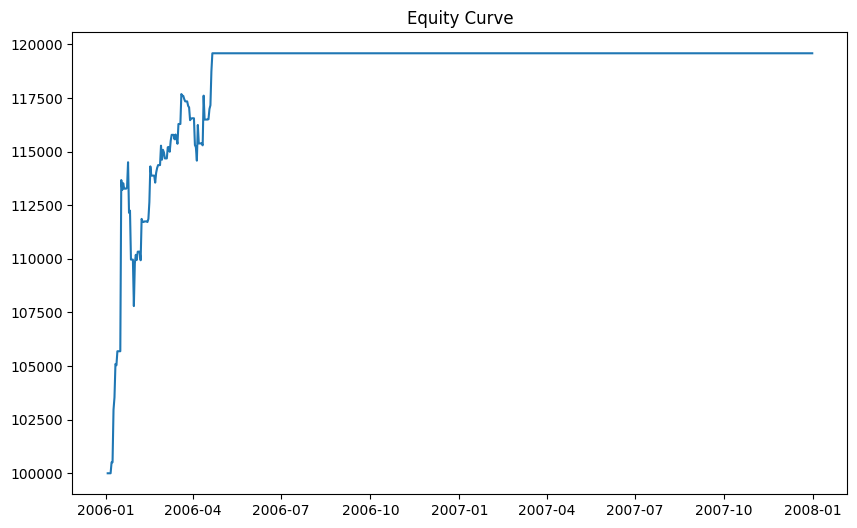

In [14]:
selection = "random_sp500_10"
strategies_folders = os.listdir(selection)
strategies_folders = ["BuyAndHoldStrategy"]

for folder in strategies_folders:
    if folder.startswith("."):
        continue

    if folder == "FinRLStrategy":
        strategies = ["FinRLStrategy/A2C", "FinRLStrategy/DDPG", "FinRLStrategy/PPO", "FinRLStrategy/SAC", "FinRLStrategy/TD3"]
    else:
        strategies = [folder]

    for strategy in strategies:
        # list all the pkl files in the subfolder
        strategy_dir = os.path.join(selection, strategy)
        strategy_files = os.listdir(strategy_dir)
        strategy_files = [file for file in strategy_files if file.endswith(".pkl")]
        if not len(strategy_files) <= 1:
            print(f"More than one pkl file found in {strategy_dir}")
            continue
        if len(strategy_files) == 0:
            continue
        else:
            data = pickle.load(open(os.path.join(strategy_dir, strategy_files[0]), "rb"))

         # plot the equity curve
        import matplotlib.pyplot as plt
        import numpy as np
        import seaborn as sns
        import matplotlib.dates as mdates

        if "GDT" in data[list(data.keys())[2]].keys():
            equity_with_time = data[list(data.keys())[2]]["GDT"]["equity_with_time"]
            equity = equity_with_time['equity']
            dates = equity_with_time['datetime']
            dates = pd.to_datetime(dates)
            # convert to datetime
            plt.figure(figsize=(10, 6))
            plt.plot(dates, equity, label="Equity Curve")
            plt.title("Equity Curve")

            # print(equity_with_time['equity'].pct_change().dropna())

        # backup the data
        os.makedirs(os.path.join(strategy_dir, "backup"), exist_ok=True)
        # check if the backup file already exists
        if os.path.exists(os.path.join(strategy_dir, "backup", strategy_files[0].replace(".pkl", ".bak"))):
            print(f"Backup file already exists: {os.path.join(strategy_dir, 'backup', strategy_files[0].replace('.pkl', '.bak'))}")
        else:
            with open(os.path.join(strategy_dir, "backup", strategy_files[0].replace(".pkl", ".bak")), "wb") as f:
                pickle.dump(data, f)

        recalculated_data = recalculate_sortino_ratio(data)
        # save the data
        with open(os.path.join(strategy_dir, strategy_files[0]), "wb") as f:
            pickle.dump(recalculated_data, f)

        aggregate_results_one_strategy(selection, strategy)

